In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import differential_evolution, basinhopping
import os

In [2]:
def workdays(start,end):
    '''
    计算两个日期间的工作日
    start:开始时间
    end:结束时间
    '''
    from datetime import datetime,timedelta
    from chinese_calendar import is_workday
     # 字符串格式日期的处理
    if type(start) == str:
        start = datetime.strptime(start,'%Y%m%d').date()
    if type(end) == str:
        end = datetime.strptime(end,'%Y%m%d').date()
    # 开始日期大，颠倒开始日期和结束日期
    if start > end:
        start,end = end,start
    counts = 0
    while True:
        if start > end:
            break
        if is_workday(start):
            counts += 1
        start += timedelta(days=1)
    return counts


In [3]:
os.chdir(r'C:\Users\Ellen\Desktop\课内\研二下\stochasitc\project\波动率数据')

In [4]:
pricecsi300 = pd.read_excel(r".\指数行情序列.xlsx")
pricecsi300

,Unnamed: 0,收盘价_x000D_\n[单位] 元,开盘价_x000D_\n[单位] 元,最高价_x000D_\n[单位] 元,最高价_x000D_\n[单位] 元.1,结算价_x000D_\n[单位] 元
0,时间,沪深300,沪深300,沪深300,沪深300,沪深300
1,2023-01-03 00:00:00,3887.8992,3864.8356,3893.9904,3893.9904,NaN
2,2023-01-04 00:00:00,3892.9477,3886.2504,3905.9032,3905.9032,NaN
3,2023-01-05 00:00:00,3968.5782,3913.4928,3974.875,3974.875,NaN
4,2023-01-06 00:00:00,3980.8888,3969.5493,4000.4143,4000.4143,NaN
...,...,...,...,...,...,...
306,2024-04-10 00:00:00,3504.7086,3528.9679,3531.2295,3531.2295,NaN
307,2024-04-11 00:00:00,3504.2447,3485.0294,3520.5893,3520.5893,NaN
308,2024-04-12 00:00:00,3475.8389,3505.7499,3516.6988,3516.6988,NaN
309,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data = pd.read_excel(r".\20231229_sell\波动率曲面.xlsx")
data

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31
0,到期,到期日,合成期货,2900.00,2950.00,3000.00,3050.00,3100.00,3150.00,3200.00,...,3850.00,3900.00,3950.00,4000.00,4100.00,4200.00,4300.00,4400.00,4500.00,4600.00
1,1M,20240128,3444.363,24.04,22.96,21.89,20.77,19.61,18.35,17.18,...,21.90,23.02,24.21,25.26,27.37,29.48,31.59,33.69,35.80,37.91
2,2M,20240228,3457.701,22.07,21.16,20.26,19.39,18.55,17.91,17.33,...,20.46,20.98,21.79,22.59,23.93,25.54,26.73,28.03,29.62,31.21
3,3M,20240328,3464.046,21.50,20.67,19.83,19.12,18.54,17.86,17.35,...,19.93,20.43,21.17,21.90,22.98,24.45,25.34,26.46,27.92,29.39
4,6M,20240628,3469.154,19.15,18.66,18.16,17.84,17.53,17.25,16.97,...,17.91,18.28,18.73,19.19,19.99,20.85,21.72,22.89,23.90,24.90
5,9M,20240928,3464.497,18.55,18.27,17.99,17.77,17.55,17.32,17.09,...,17.21,17.44,17.70,17.97,18.26,18.76,19.25,19.74,20.24,20.73
6,1Y,20241228,3486.69,17.98,17.83,17.68,17.50,17.32,17.15,16.99,...,16.36,16.18,16.00,15.81,15.45,15.09,14.73,14.37,14.00,13.64


In [6]:
from SVI import OptSVI1test
dataarr = data.values
K = dataarr[0,3:]
TT = [30,60,90,180,270,365]
#TT = [20, 40, 60, 120,180, 250]
#TT = [workdays('20231229',i) for i in data.iloc[1:, 1]]
#S0 = 3475.8389
S = dataarr[1:, 2]
w = np.ones((6, 30))  # weights for each option
Vol = np.array(dataarr[1:,3:]) * 0.01

p = np.ones((6, 5)) * 0.0 # initial guess for SVI parameters
p[4:,:] = 0.003
for i in range(6):
    # S0 = S[i]
    S0 = 3431.1099
    fun = lambda p: OptSVI1test(i, Vol, w, p, K, S0, TT)
    res = basinhopping(fun, p[i,:],niter=1000)
    #res = minimize(fun, p[i,:], options={'maxiter': 1000})
    p[i,:] = res.x

print(p)

[[-8.43370779e-01 -2.01226973e-01  1.72045504e+00  3.68207993e+00
  -9.00988966e+00]
 [-4.33269419e-01  1.19122303e+00 -8.41162291e-01 -1.07636567e+00
   4.62150081e-01]
 [-7.81737528e-02  1.85338170e-01 -2.25576743e-01 -1.23813282e-01
   2.22367859e-01]
 [-2.68977119e-01  4.36944670e-01  5.38387368e-01  4.90490199e-01
   5.88743311e-01]
 [-3.88807325e+00 -3.72379935e+00 -1.14094072e+00 -3.95639535e+00
  -3.65088046e+00]
 [ 8.88288260e-02 -4.56437217e-03  3.52922624e+00 -3.74041995e+00
  -1.51279548e+01]]


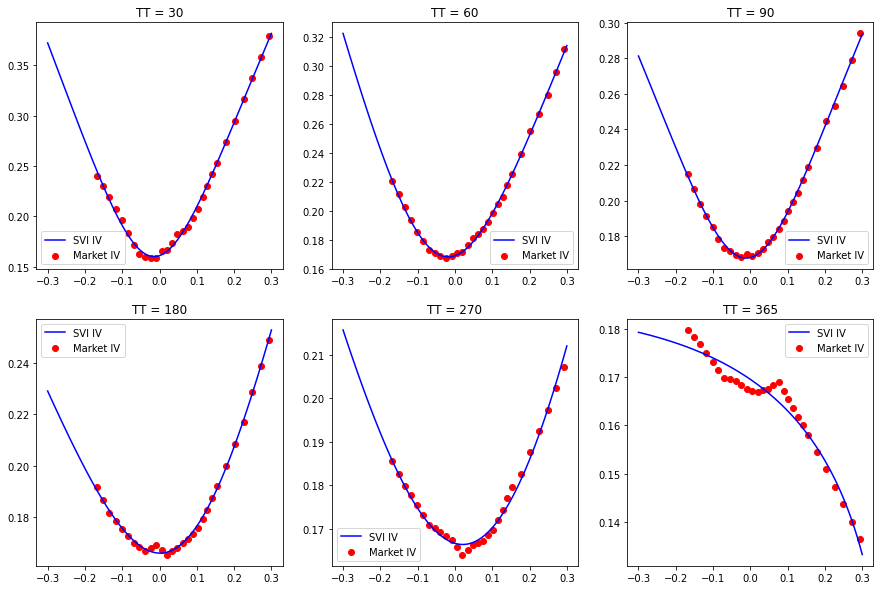

In [7]:
p = np.load('para_svi.npy')
fig, ax = plt.subplots(2, 3, figsize=(15, 10))  # 创建一个2x3的子图网格
for i in range(6):
    S0 = 3431.1099
    #S0 = S[i]
    f = lambda x: np.sqrt(np.maximum(p[i, 0] + p[i, 1] * (p[i, 2] * (x - p[i, 3]) + np.sqrt((x - p[i, 3]) ** 2 + p[i, 4])), 0)) / np.sqrt(TT[i] / 365)
    x = np.linspace(-0.3, 0.3, 100)
    ax[i//3, i%3].plot(x, f(x),label = 'SVI IV', color='b')  # 选择子图
    ImpVol = Vol[i,:]
    x = np.array(K / S0).astype(float)
    ax[i//3, i%3].scatter(np.log(x), ImpVol,label='Market IV',color='r')
    ax[i//3, i%3].set_title('TT = %d' % TT[i])
    ax[i//3, i%3].legend()
    
plt.show()
fig.savefig('subplot.jpg')  # 保存整个子图网格为一个jpg文件

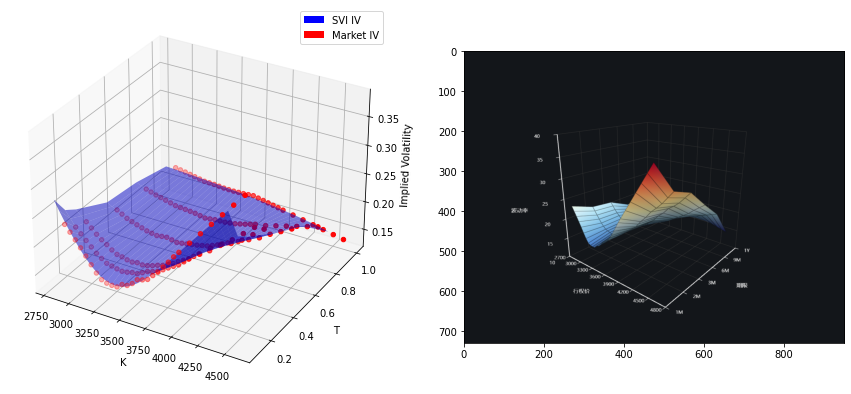

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.image import imread

# Create a figure with two subplots, one of which is a 3D plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

Z = []
for i in range(6):
    f = lambda x: np.sqrt(np.maximum(p[i, 0] + p[i, 1] * (p[i, 2] * (x - p[i, 3]) + np.sqrt((x - p[i, 3]) ** 2 + p[i, 4])), 0)) / np.sqrt(TT[i] / 365)
    x = (np.arange(2800, 4500, 50) / S0)
    Z.append(f(np.log(x)))

X, Y = np.meshgrid(np.arange(2800, 4500, 50),np.array(TT) / 365)
ax.plot_surface(X, Y, np.array(Z), alpha=0.5, color='blue')

xx = np.array(TT) / 365
ax.scatter(K, np.ones(len(K))*xx[0], Vol[0,:], color='red')
ax.scatter(K, np.ones(len(K))*xx[1], Vol[1,:], color='red')
ax.scatter(K, np.ones(len(K))*xx[2], Vol[2,:], color='red')
ax.scatter(K, np.ones(len(K))*xx[3], Vol[3,:], color='red')
ax.scatter(K, np.ones(len(K))*xx[4], Vol[4,:], color='red')
ax.scatter(K, np.ones(len(K))*xx[5], Vol[5,:], color='red')

ax.set_xlabel('K')
ax.set_ylabel('T')
ax.set_zlabel('Implied Volatility')

legend_elements = [Patch(facecolor='blue', label='SVI IV'),
                   Patch(facecolor='red', label='Market IV')]
ax.legend(handles=legend_elements)

# Load image from local file
img = imread(r'./20231229_sell/波动率曲面.png')

# Display the image
ax2.imshow(img)

plt.show()
fig.savefig('surface.jpg')

In [22]:
# np.save('para_svi.npy', p)

In [9]:
import numpy as np
import pyfeng as pf
# sigma: model volatility or variance at t=0.
# vov: volatility of volatility
# rho: correlation between price and volatility
# mr: mean-reversion speed (kappa)
# theta: long-term mean of volatility or variance. If None, same as sigma
# intr: interest rate (domestic interest rate)
# divr: dividend/convenience yield (foreign interest rate)
# is_fwd: if True, treat `spot` as forward price. False by default.
strike = np.arange(2900, 3500, 50)
sigma, vov, mr, rho, texp, spot = 0.3, 1, 0.5, -0.9, 20, 3431.1099

m = pf.HestonMcAndersen2008(sigma, vov=vov, mr=mr, rho=rho)
m.set_num_params(n_path=1e5, dt=1/8, rn_seed=123456)
m.price(strike, spot, texp)

array([2217.66209952, 2203.44069611, 2189.34710739, 2175.37931234,
       2161.53534736, 2147.81330385, 2134.21132577, 2120.72760747,
       2107.36039156, 2094.10796695, 2080.96866697, 2067.94086761])

In [10]:
m = pf.HestonFft(sigma, vov=vov, mr=mr, rho=rho)
print('true price:', m.price(strike, spot, texp))
m.price(strike, spot, texp)

true price: [2223.35850353 2209.14333224 2195.05524382 2181.09223049 2167.25234199
 2153.53368304 2139.93441097 2126.45273346 2113.08690643 2099.83523204
 2086.69605681 2073.6677698 ]


array([2223.35850353, 2209.14333224, 2195.05524382, 2181.09223049,
       2167.25234199, 2153.53368304, 2139.93441097, 2126.45273346,
       2113.08690643, 2099.83523204, 2086.69605681, 2073.6677698 ])

In [11]:
# Heaton-Dupire
from heston_mc import HestonMcAndersen2008
m = HestonMcAndersen2008(sigma, vov=vov, mr=mr, rho=rho)
m.set_num_params(n_path=1e5, dt=1/8, rn_seed=123456)
res = m.price(strike, spot, texp)
print('Heaton-Dupire price:',res)
print('end')

  3%|▎         | 5/160 [00:09<04:45,  1.84s/it]C:\Users\Ellen\Desktop\课内\研二下\stochasitc\Github\PyFENG-fork\project\heston_mc.py:162: RuntimeWarning: divide by zero encountered in double_scalars
  fn_1 = (p[i + 1, 1] / (2 * sign_1)) * (p[i + 1, 2] + (x - p[i + 1, 3]) / np.sqrt(max((x - p[i + 1, 3])**2 + p[i + 1, 4], 0)))
C:\Users\Ellen\Desktop\课内\研二下\stochasitc\Github\PyFENG-fork\project\heston_mc.py:164: RuntimeWarning: invalid value encountered in double_scalars
  gn_1 = (p[i + 1, 1] * p[i + 1, 4] / (2 * ((x - p[i + 1, 3])**2 + p[i + 1, 4])**(3 / 2)) - fn_1**2) / sign_1
C:\Users\Ellen\Desktop\课内\研二下\stochasitc\Github\PyFENG-fork\project\heston_mc.py:169: RuntimeWarning: invalid value encountered in double_scalars
  SigmaLV = np.sqrt(max((sig**2 + 2 * t_real / 365 * sig * (sig_T + r * sig_x)) / ((1 + d1 * np.sqrt(t_real / 365) * sig_x)**2 + sig * t_real / 365 * (sig_xx - sig_x - d1 * np.sqrt(t_real / 365) * (sig_x)**2)), 10**(-5)))
C:\Users\Ellen\Desktop\课内\研二下\stochasitc\Github\PyFENG

Heston-Dupire:  [394.40518602 374.64875346 355.16480863 335.96103381 317.05901347
 298.45781451 280.1801458  262.2564067  244.70676605 227.5466253
 210.8057186  194.4946924 ]
Heaton-Dupire price: [nan nan nan nan nan nan nan nan nan nan nan nan]
end


In [22]:
p

array([[-2.18524232e+03,  2.68883908e+03, -3.97013511e-01,
        -4.06001228e-01,  7.99332822e-01],
       [-1.81026322e+03,  3.05008751e+03, -5.04652788e-01,
        -4.38437700e-01,  4.97269794e-01],
       [-5.48297038e+02,  1.54812065e+03, -1.64949615e-01,
        -9.13908458e-02,  1.63791427e-01],
       [-5.98755376e+02,  1.87940281e+03,  3.91476719e-01,
         1.71949192e-01,  1.80258448e-01],
       [ 1.21579402e+02,  6.06473966e+02,  1.94323842e-01,
         4.37973412e-02,  1.84887641e-02],
       [ 1.41966172e+02,  1.25326612e+03, -1.11414370e+00,
        -1.08957269e+02,  2.89131828e+03]])